In [20]:
import yfinance as yf

# Define the ticker symbol
symbol = "MSFT"

# Create a Ticker object for the symbol
ticker = yf.Ticker(symbol)

# Get the available options expirations
expirations = ticker.options

# Get the options chain for the expiration date
options_chain = ticker.option_chain()

# Get the call options and their prices for different strikes
calls = options_chain.calls
call_strikes = calls.strike
call_prices = calls.lastPrice

# Get the put options and their prices for different strikes
puts = options_chain.puts
put_strikes = puts.strike
put_prices = puts.lastPrice

In [25]:
info = ticker.get_info()
refprice = info['open']

In [65]:
from scipy.stats import norm
import numpy as np

def black_scholes(S, K, T, r, sigma, option_type):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == 'call':
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)


def df_bs(row):
    S = row['underlying_price']
    K = row['strike']
    T = row['yte']
    r = 0.04 # risk-free interest rate
    sigma = row['impliedVolatility']

    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if row['option_type'] == 'call':
        price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif row['option_type'] == 'put':
        price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)

    return price

<Axes: xlabel='strike'>

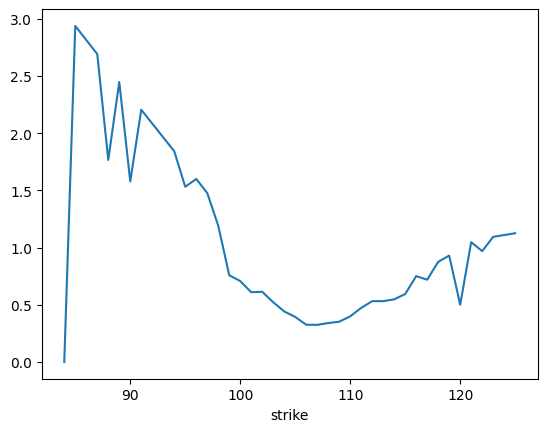

In [66]:
bound = 0.2
mask = (calls.strike > refprice * (1 - bound)) | (calls.strike < refprice * (1 + bound))
filtered_calls = calls[mask].set_index("strike")
filtered_calls['impliedVolatility'].plot()

C:\Users\allen\AppData\Local\Temp\ipykernel_28200\3967007291.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  calls = calls[mask]


<Axes: xlabel='strike'>

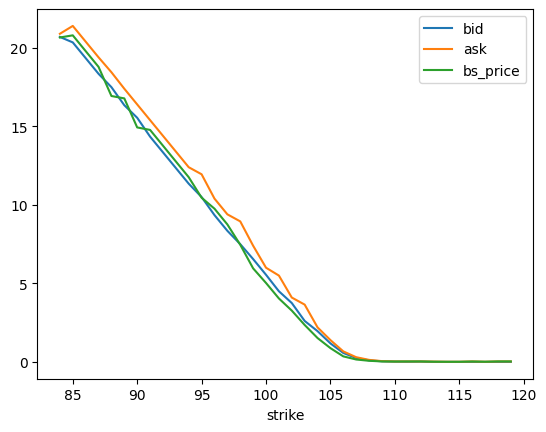

In [76]:
from datetime import datetime
calls = calls[mask]
calls['underlying_price'] = refprice
calls['yte'] = np.busday_count(datetime.today().date(), datetime(2023, 4, 21, 16, 0).date()) / 252.0
calls['option_type'] = "call"
calls['bs_price'] = calls.apply(df_bs, axis=1)
calls[calls.strike < 120].set_index("strike")[['bid', 'ask', 'bs_price']].plot()

<Axes: xlabel='strike'>

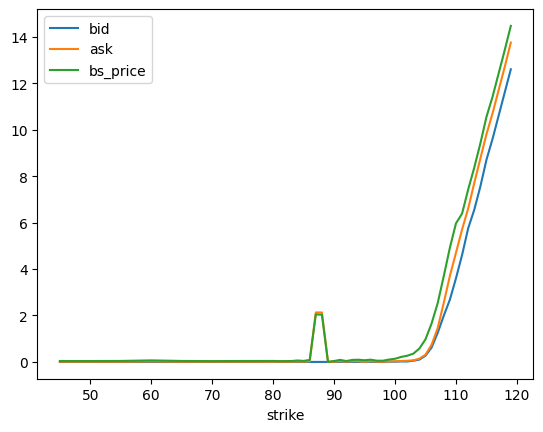

In [78]:
from datetime import datetime
mask = (puts.strike > refprice * (1 - bound)) | (puts.strike < refprice * (1 + bound))
puts = puts[mask]
puts['underlying_price'] = refprice
puts['yte'] = np.busday_count(datetime.today().date(), datetime(2023, 4, 21, 16, 0).date()) / 252.0
puts['option_type'] = "put"
puts['bs_price'] = puts.apply(df_bs, axis=1)
puts[puts.strike < 120].set_index("strike")[['bid', 'ask', 'bs_price']].plot()